In [1]:
import numpy as np
import pandas as pd

import os, glob

from collections import OrderedDict

import matplotlib
import matplotlib.pyplot as plt

import ipywidgets as widgets
from traitlets import dlink
from IPython.display import display

from pyrixs import process1d

%matplotlib nbagg

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show/hide code."></form>''')


In [3]:
Data = OrderedDict({
'spectra' : pd.DataFrame([]),
'spectrum' : pd.Series([]),
'shifts' : pd.Series([]),
'meta' : ''
})

In [4]:
######################################
# Widgets
######################################

# Folder to search data for
folder_widget = widgets.Text(
    value='test_data/*.txt',  #'./../../LSCO/ID08data/id08/Spectra/'
    description='Search path'
)

# Display and pick which spectra to plot
select_spectra_widget = widgets.SelectMultiple(
            options=process1d.get_all_spectra_names(folder_widget.value),
            description='Select spectra'
            )

# Dropdown menu to pick reference spectrum
ref_widget = widgets.Dropdown(
    description='Reference spectrum',
    disabled=False,
    button_style='' 
)

# Button to plot the data
plot_button_widget = widgets.Button(
    description='Plot',
)

# Min value for alignment
min_align_widget = widgets.FloatText(
    value=0.,
    width='150px',
    description='Min x',
)

# Max value for alignment
max_align_widget = widgets.FloatText(
    value=2000.,
    width='150px',
    description='Max x',
)

# Background value for alignment
background_widget = widgets.FloatText(
    value=0.,
    width='150px',
    description='BG',
)


# Button to align the spectra
align_button_widget = widgets.Button(
    description='Align',
)

# Dropdown menu to choose alignment method
pick_ailgnment_widget = widgets.Dropdown(
    options=['Correlate', 'Correlate mean'],
    value='Correlate',
    description='Method',
    disabled=False,
    button_style='' 
)

# Button to sum the spectra
sum_button_widget = widgets.Button(
    description='Sum',
)

# Pixel corresponding to zero energy for calibration
zero_E_widget = widgets.FloatText(
    value=0,
    description='Zero energy pixel',
)

# Energy per pixel for calibration
energy_per_pixel_widget = widgets.FloatText(
    value=1,
    description='Energy per pixel',
)

# Button to calibrate
calibrate_widget = widgets.Button(
    description='Calibrate',
)

# Path to save final spectrum
path_save_widget = widgets.Text(
    value='out.dat',
    description='Save path',
)

# Button to save
save_widget = widgets.Button(
    description='Save',
)

In [5]:
###########################
## Widget logic
###########################
def update_select_spectra_widget(change):
    """Refresh filenames in for selection"""
    select_spectra_widget.options = process1d.get_all_spectra_names(folder_widget.value)
    ref_widget.options = select_spectra_widget.value
    
folder_widget.on_submit(update_select_spectra_widget)

dl = dlink((select_spectra_widget, 'value'), (ref_widget, 'options'))

def wrap_load_spectra(search_path, selected_file_names):
    Data['spectra'] = process1d.load_spectra(search_path, selected_file_names)
#search_select_widget = widgets.interactive(Data['spectra']=process1d.load_spectra, search_path=folder_widget.value, selected_file_names=select_spectra_widget)
#search_select_widget = widgets.interactive(process1d.load_spectra, search_path=folder_widget.value, selected_file_names=select_spectra_widget)
search_select_widget = widgets.interactive(wrap_load_spectra, search_path=folder_widget.value, selected_file_names=select_spectra_widget)

def wrap_plot(change):
    """Pass widget values for plotting the spectra"""
    process1d.plot_spectra(ax1, Data['spectra'], align_min=min_align_widget.value, align_max=max_align_widget.value)

plot_button_widget.on_click(wrap_plot)

def wrap_align(change):
    """Pass widget values for aligning the spectra"""
    if pick_ailgnment_widget.value == 'Correlate':
        Data['shifts'] = process1d.get_shifts(Data['spectra'], ref_widget.value, align_min=min_align_widget.value,
                               align_max=max_align_widget.value, background=background_widget.value)
    elif pick_ailgnment_widget.value == 'Correlate mean':
        raise NameError("Mean function needs updating now....")
    #    shifts = process1d.get_shifts_w_mean(ref_widget.value, align_min=min_align_widget.value,
    #                           align_max=max_align_widget.value, background=background_widget.value)
    Data['spectra'] = process1d.apply_shifts(Data['spectra'], Data['shifts'])
    process1d.plot_spectra(ax1, Data['spectra'], align_min=min_align_widget.value, align_max=max_align_widget.value)
    process1d.plot_shifts(ax2, Data['shifts'])

align_button_widget.on_click(wrap_align)

def wrap_sum(change):
    """When sum is clicked spectra are summed and plotted"""
    Data['spectrum'], Data['meta'] = process1d.sum_spectra(Data['spectra'], Data['shifts'])
    process1d.plot_sum(ax3, Data['spectrum'])

sum_button_widget.on_click(wrap_sum)

def wrap_calibrate(change):
    """Pass widget values for calibrating the spectra and then plot"""
    Data['spectrum'] = process1d.calibrate_spectrum(Data['spectrum'], zero_E_widget.value, energy_per_pixel_widget.value)
    process1d.plot_sum(ax3, Data['spectrum'])

calibrate_widget.on_click(wrap_calibrate)

def wrap_save(change):
    """Pass widget values for saving"""
    process1d.save_spectrum(path_save_widget.value, Data['spectrum'], Data['meta'])

save_widget.on_click(wrap_save)

## List and choose spectra

In [6]:
display(folder_widget, select_spectra_widget, ref_widget)

## Plot spectra

<IPython.core.display.Javascript object>


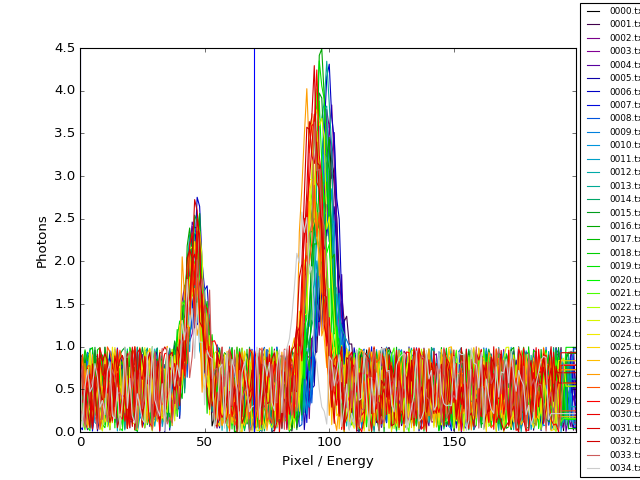

<IPython.core.display.Javascript object>


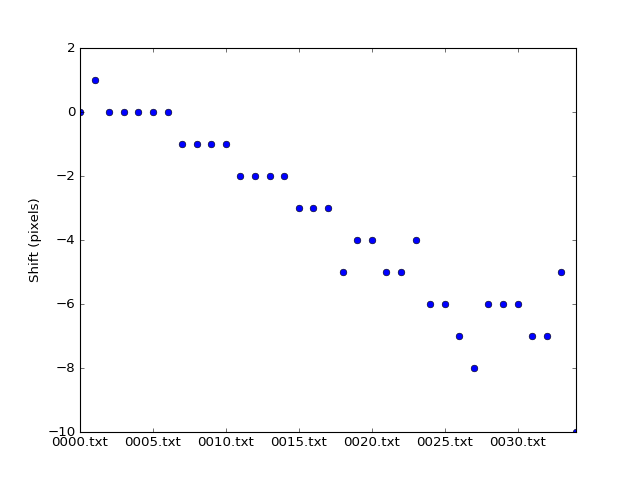

In [7]:
plt.figure(1)
ax1 = plt.subplot(111)

plt.figure(2)
ax2 = plt.subplot(111)
ax2.hold(False)

widgets.VBox([widgets.HBox([min_align_widget, max_align_widget, background_widget]),
             widgets.HBox([plot_button_widget, align_button_widget, pick_ailgnment_widget])])



## Sum and calibrate spectra

<IPython.core.display.Javascript object>


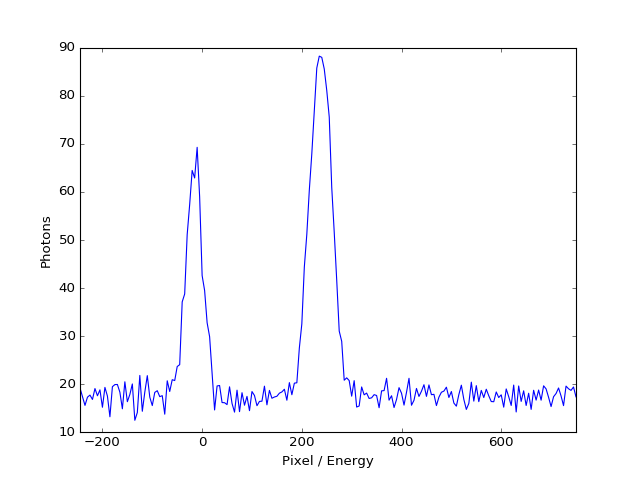

In [8]:
plt.figure(3)
ax3 = plt.subplot(111)
ax3.hold(False)

widgets.VBox([widgets.HBox([zero_E_widget, energy_per_pixel_widget]), 
             widgets.HBox([sum_button_widget, calibrate_widget])])

In [9]:
Data['spectrum']

Series([], dtype: float64)

## Save final spectrum

In [10]:
widgets.HBox([path_save_widget, save_widget])